In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Loading the Dataset


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted /content/drive/My Drive/eye_images.zip to /content/eye_images_extracted


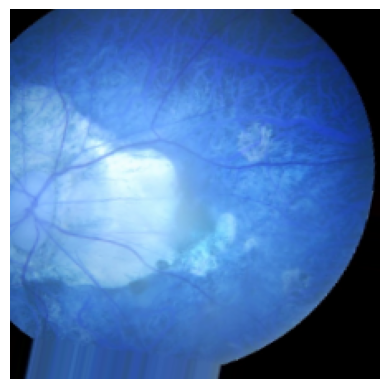

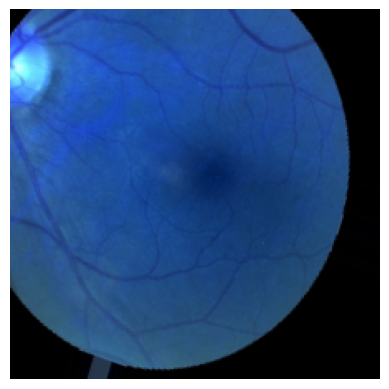

In [ ]:
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import random

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define path to the ZIP
zip_file_path = '/content/drive/My Drive/eye_images.zip'

# Step 3: Extract once
extract_to_folder = '/content/eye_images_extracted'

def extract_zip(zip_file, extract_to_folder):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)
    print(f"Extracted {zip_file} to {extract_to_folder}")

# Only extract if not already extracted
if not os.path.exists(extract_to_folder):
    extract_zip(zip_file_path, extract_to_folder)

# Step 4: Define paths to the extracted folders
myopic_folder = os.path.join(extract_to_folder, 'myopic')
normal_folder = os.path.join(extract_to_folder, 'normal')

# Step 5: Load images
def load_images_from_folder(folder_path, num_images=1000):
    images = []
    all_filenames = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    selected_filenames = random.sample(all_filenames, min(num_images, len(all_filenames)))

    for filename in selected_filenames:
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            images.append(image)
    return images

# Step 6: Load 1000 images from each folder
myopic_images = load_images_from_folder(myopic_folder, 1000)
normal_images = load_images_from_folder(normal_folder, 1000)

# Step 7: Show a sample image
def process_and_display_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Display one sample myopic and normal image
process_and_display_image(myopic_images[0])
process_and_display_image(normal_images[0])


# Plotting Histogram of colors for one image each from myopic and normal eye


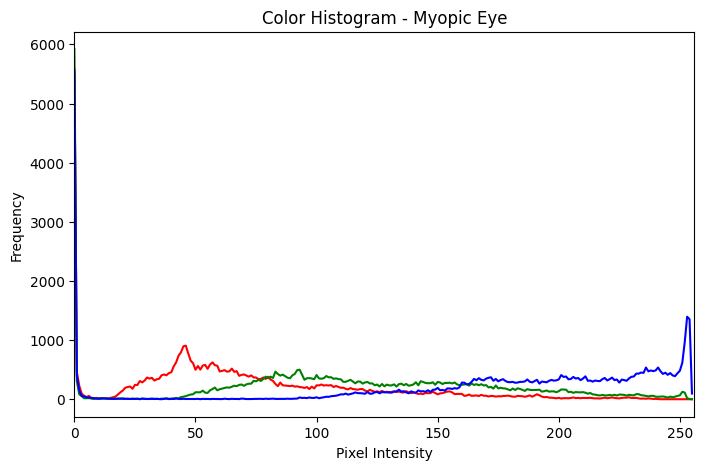

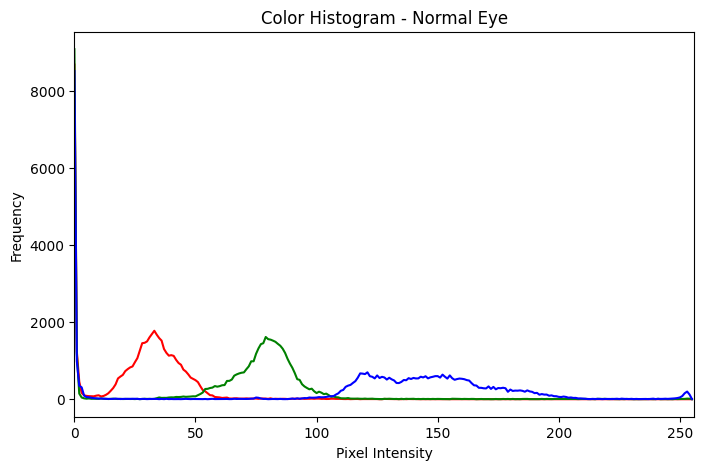

In [ ]:
import cv2
import matplotlib.pyplot as plt

def plot_color_histogram(image, title):
    # Convert BGR (OpenCV default) to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Split into channels
    channels = ('r', 'g', 'b')
    colors = ('red', 'green', 'blue')

    plt.figure(figsize=(8, 5))
    plt.title(f'Color Histogram - {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    # Plot histogram for each channel
    for (channel, color) in zip(range(3), colors):
        hist = cv2.calcHist([image_rgb], [channel], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])

    plt.show()

# Pick sample images
sample_myopic = myopic_images[0]
sample_normal = normal_images[0]

# Plot histograms
plot_color_histogram(sample_myopic, "Myopic Eye")
plot_color_histogram(sample_normal, "Normal Eye")



# Plotting Histogram of colors by averaging 1000 images each from myopic and normal


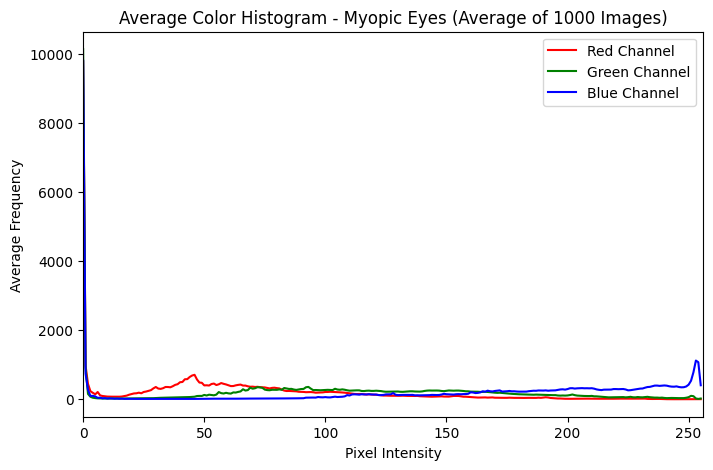

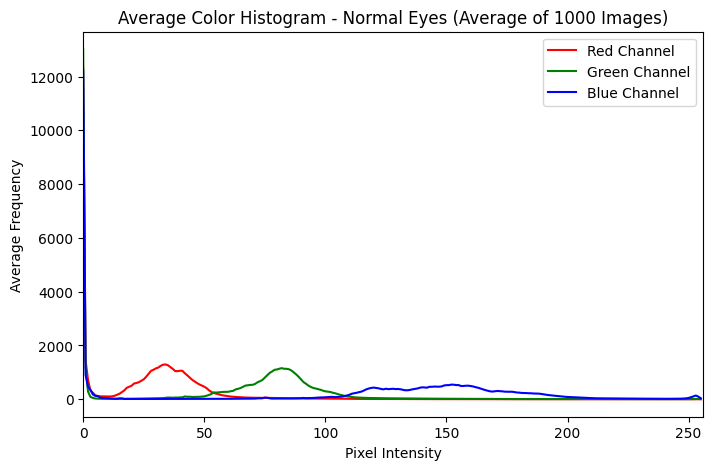

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def calculate_average_histogram(images):
    # Initialize cumulative histograms
    r_hist = np.zeros((256,))
    g_hist = np.zeros((256,))
    b_hist = np.zeros((256,))

    for image in images:
        # Convert BGR (OpenCV default) to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Calculate histogram for each channel
        for i, hist_array in enumerate([r_hist, g_hist, b_hist]):
            hist = cv2.calcHist([image_rgb], [i], None, [256], [0, 256])
            hist_array += hist.flatten()

    # Average the histograms
    r_hist /= len(images)
    g_hist /= len(images)
    b_hist /= len(images)

    return r_hist, g_hist, b_hist

def plot_average_histogram(r_hist, g_hist, b_hist, title):
    plt.figure(figsize=(8, 5))
    plt.title(f'Average Color Histogram - {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Average Frequency')

    plt.plot(r_hist, color='red', label='Red Channel')
    plt.plot(g_hist, color='green', label='Green Channel')
    plt.plot(b_hist, color='blue', label='Blue Channel')

    plt.legend()
    plt.xlim([0, 256])
    plt.show()

# Calculate average histograms
r_hist_myopic, g_hist_myopic, b_hist_myopic = calculate_average_histogram(myopic_images)
r_hist_normal, g_hist_normal, b_hist_normal = calculate_average_histogram(normal_images)

# Plot average histograms
plot_average_histogram(r_hist_myopic, g_hist_myopic, b_hist_myopic, "Myopic Eyes (Average of 1000 Images)")
plot_average_histogram(r_hist_normal, g_hist_normal, b_hist_normal, "Normal Eyes (Average of 1000 Images)")


# Feature Extraction


In [ ]:
import os
import cv2
import numpy as np
from skimage.measure import shannon_entropy
from tqdm import tqdm

# Feature extraction function
def extract_all_features(image):
    # Convert to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Split channels
    r_channel = image_rgb[:, :, 0]
    g_channel = image_rgb[:, :, 1]
    b_channel = image_rgb[:, :, 2]

    # Calculate RGB means
    r_mean = np.mean(r_channel)
    g_mean = np.mean(g_channel)
    b_mean = np.mean(b_channel)

    # Color ratios
    rg_ratio = r_mean / (g_mean + 1e-5)
    rb_ratio = r_mean / (b_mean + 1e-5)

    # Grayscale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Mean brightness and contrast
    brightness = np.mean(gray)
    contrast = np.std(gray)

    # Entropy
    entropy_value = shannon_entropy(gray)

    # Edge detection (Canny)
    edges = cv2.Canny(gray, threshold1=50, threshold2=150)
    edge_count = np.sum(edges > 0)

    # Blurriness detection (Laplacian variance)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    return [brightness, contrast, r_mean, g_mean, b_mean, rg_ratio, rb_ratio, entropy_value, edge_count, laplacian_var]

# Function to load and extract features
def load_images_and_extract_features(folder_path, label, num_images=1000):
    features = []
    labels = []
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png'))][:num_images]

    for filename in tqdm(image_files, desc=f"Processing {label} images"):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)

        if image is not None:
            feats = extract_all_features(image)
            features.append(feats)
            labels.append(label)

    return features, labels

# Paths (adjust if needed)
# Paths updated
myopic_folder = '/content/eye_images_extracted/myopic'
normal_folder = '/content/eye_images_extracted/normal'


# Load and process images
myopic_features, myopic_labels = load_images_and_extract_features(myopic_folder, label=1)
normal_features, normal_labels = load_images_and_extract_features(normal_folder, label=0)

# Combine
X = np.array(myopic_features + normal_features)
y = np.array(myopic_labels + normal_labels)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")



Processing 0 images: 100%|██████████| 1000/1000 [00:08<00:00, 114.37it/s]

Feature matrix shape: (2000, 10)
Labels shape: (2000,)


# Printing features for some of the images

In [ ]:
import pandas as pd
import cv2
import os
import random
import numpy as np

# Define the folder paths (already extracted)
myopic_folder = '/content/eye_images_extracted/myopic'
normal_folder = '/content/eye_images_extracted/normal'

# Feature extraction functions
def extract_brightness(image):
    return np.mean(image)

def extract_contrast(image):
    return np.std(image)

def extract_mean_color(image):
    (B, G, R) = cv2.split(image)
    return np.mean(R), np.mean(G), np.mean(B)

def extract_rg_ratio(image):
    R, G, _ = extract_mean_color(image)
    return R / (G + 1e-5)  # Avoid division by zero

def extract_rb_ratio(image):
    R, _, B = extract_mean_color(image)
    return R / (B + 1e-5)

def extract_entropy(image):
    return cv2.calcHist([image], [0], None, [256], [0, 256]).flatten().mean()

def extract_edge_count(image):
    edges = cv2.Canny(image, 100, 200)
    return np.sum(edges > 0)

def extract_blurriness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# Load images function
def load_images_from_folder(folder_path, num_images=1000):
    images = []
    all_filenames = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    selected_filenames = random.sample(all_filenames, min(num_images, len(all_filenames)))

    for filename in selected_filenames:
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            images.append(image)
    return images

# Function to extract features from an image
def extract_features(image):
    brightness = extract_brightness(image)
    contrast = extract_contrast(image)
    r_mean, g_mean, b_mean = extract_mean_color(image)
    rg_ratio = extract_rg_ratio(image)
    rb_ratio = extract_rb_ratio(image)
    entropy = extract_entropy(image)
    edge_count = extract_edge_count(image)
    blurriness = extract_blurriness(image)
    return [brightness, contrast, r_mean, g_mean, b_mean, rg_ratio, rb_ratio, entropy, edge_count, blurriness]

# Load 1000 images from each folder
myopic_images = load_images_from_folder(myopic_folder, 1000)
normal_images = load_images_from_folder(normal_folder, 1000)

# Extract features for each image
myopic_features = [extract_features(img) for img in myopic_images]
normal_features = [extract_features(img) for img in normal_images]

# Create labels: 1 for myopic, 0 for normal
myopic_labels = [1] * len(myopic_features)
normal_labels = [0] * len(normal_features)

# Combine all features and labels
features = myopic_features + normal_features
labels = myopic_labels + normal_labels

# Create a DataFrame
columns = ['Brightness', 'Contrast', 'Red Mean', 'Green Mean', 'Blue Mean', 'RG Ratio', 'RB Ratio', 'Entropy', 'Edge Count', 'Blurriness']
df = pd.DataFrame(features, columns=columns)
df['Label'] = labels

# Display the DataFrame
print(df.head())  # This will show the first few rows (you can also use df.head() to see a preview)


   Brightness   Contrast   Red Mean  Green Mean   Blue Mean  RG Ratio  \
0  118.539514  77.477355  69.033602  112.658662  173.926279  0.612768   
1  104.575999  85.758809  63.139429  100.872588  149.715980  0.625932   
2  107.770734  80.899112  62.799007  102.284379  158.228815  0.613965   
3  112.803339  81.188853  66.460658  107.838449  164.110910  0.616298   
4  126.150796  75.385128  74.427934  120.321728  183.702726  0.618574   

   RB Ratio  Entropy  Edge Count  Blurriness  Label  
0  0.396913    196.0        1223  107.479837      1  
1  0.421728    196.0         997   86.972214      1  
2  0.396887    196.0        1132  109.816614      1  
3  0.404974    196.0        1019   95.223240      1  
4  0.405154    196.0        1058   85.775187      1  


Accuracy: 97.50%

Confusion Matrix:
[[194   7]
 [  3 196]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       201
           1       0.97      0.98      0.98       199

    accuracy                           0.97       400
   macro avg       0.98      0.98      0.97       400
weighted avg       0.98      0.97      0.97       400



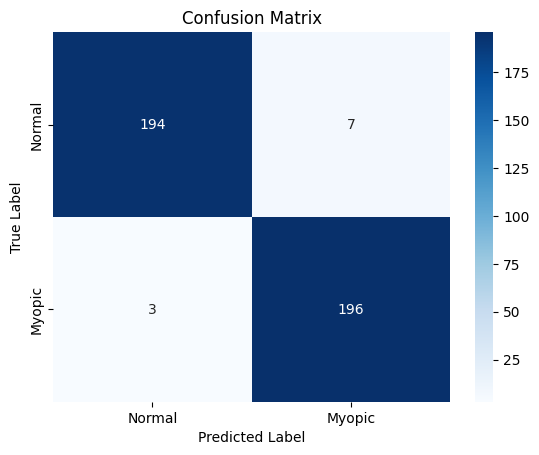

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df` is the DataFrame with features and labels
# Split data into features (X) and labels (y)
X = df.drop('Label', axis=1)
y = df['Label']

# Step 1: Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Initialize and train the model (Random Forest Classifier)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = model.predict(X_test)

# Step 4: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Displaying results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Plotting confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Myopic'], yticklabels=['Normal', 'Myopic'])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
import cv2
import numpy as np

# Define the feature extraction functions
def extract_brightness(image):
    return np.mean(image)

def extract_contrast(image):
    return np.std(image)

def extract_mean_color(image):
    (B, G, R) = cv2.split(image)
    return np.mean(R), np.mean(G), np.mean(B)

def extract_rg_ratio(image):
    R, G, _ = extract_mean_color(image)
    return R / (G + 1e-5)

def extract_rb_ratio(image):
    R, _, B = extract_mean_color(image)
    return R / (B + 1e-5)

def extract_entropy(image):
    return cv2.calcHist([image], [0], None, [256], [0, 256]).flatten().mean()

def extract_edge_count(image):
    edges = cv2.Canny(image, 100, 200)
    return np.sum(edges > 0)

def extract_blurriness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# Function to extract features for an image
def extract_features(image):
    brightness = extract_brightness(image)
    contrast = extract_contrast(image)
    r_mean, g_mean, b_mean = extract_mean_color(image)
    rg_ratio = extract_rg_ratio(image)
    rb_ratio = extract_rb_ratio(image)
    entropy = extract_entropy(image)
    edge_count = extract_edge_count(image)
    blurriness = extract_blurriness(image)
    return [brightness, contrast, r_mean, g_mean, b_mean, rg_ratio, rb_ratio, entropy, edge_count, blurriness]

# Function to predict whether the image is myopic or normal
def predict_image(image_path):
    # Load image
    image = cv2.imread(image_path)

    # Check if image was loaded successfully
    if image is None:
        print(f"Error: Image not found at {image_path}")
        return None

    # Extract features from the image
    features = extract_features(image)

    # Reshape the features to match the model's input shape
    features = np.array(features).reshape(1, -1)

    # Make prediction (assuming the model is already trained)
    prediction = model.predict(features)

    # Return prediction result
    if prediction == 1:
        return "Myopic"
    else:
        return "Normal"

# Example usage: Predict for a new image
image_path = 'myopia271.png'  # Change this to your image path
result = predict_image(image_path)

if result:
    print(f"The image is classified as: {result}")


The image is classified as: Myopic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
